In [6]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [2]:
%matplotlib notebook

Get the data from IBL format

In [7]:
!pip install --quiet nma-ibl

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ray 1.7.0 requires msgpack<2.0.0,>=1.0.0, which is not installed.
You should consider upgrading via the '/Users/monikawysoczanska/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [9]:
import datajoint as dj
dj.config['database.host'] = 'datajoint-public.internationalbrainlab.org'
dj.config['database.user'] = 'ibl-public'
dj.config['database.password'] = 'ibl-public'
from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses

[2023-07-18 09:46:15,130][INFO]: Connecting ibl-public@datajoint-public.internationalbrainlab.org:3306
[2023-07-18 09:46:16,500][INFO]: Connected ibl-public@datajoint-public.internationalbrainlab.org:3306


In [15]:
data = ((behavior.TrialSet.Trial & 'trial_response_choice !="No Go"') * (subject.Subject & 'subject_birth_date > "2019-08-01"') * acquisition.Session * behavior_analyses.PsychResultsBlock).fetch(format='frame')


In [21]:
pickle.dump(data, open('data.p', 'wb'))

## Data reading

In [22]:
with open('data.p', 'rb') as f:
    data = pickle.load(f)

The columns that we have

In [23]:
pd.DataFrame(data.columns)

,0
0,trial_start_time
1,trial_end_time
2,trial_response_time
3,trial_response_choice
4,trial_stim_on_time
5,trial_stim_contrast_left
6,trial_stim_contrast_right
7,trial_feedback_time
8,trial_feedback_type
9,trial_rep_num


## Preprocessing 

In [4]:
data = data.reset_index()
data['subject_uuid'] = data['subject_uuid'].astype('string')
data['session_uuid'] = data['session_uuid'].astype('string')

In [5]:
len(data)

1686341

Getting the dataframe for one subject

In [233]:
s_uuid = '01be78e7-8741-4b40-bd64-79ed745431b5'

<IPython.core.display.Javascript object>


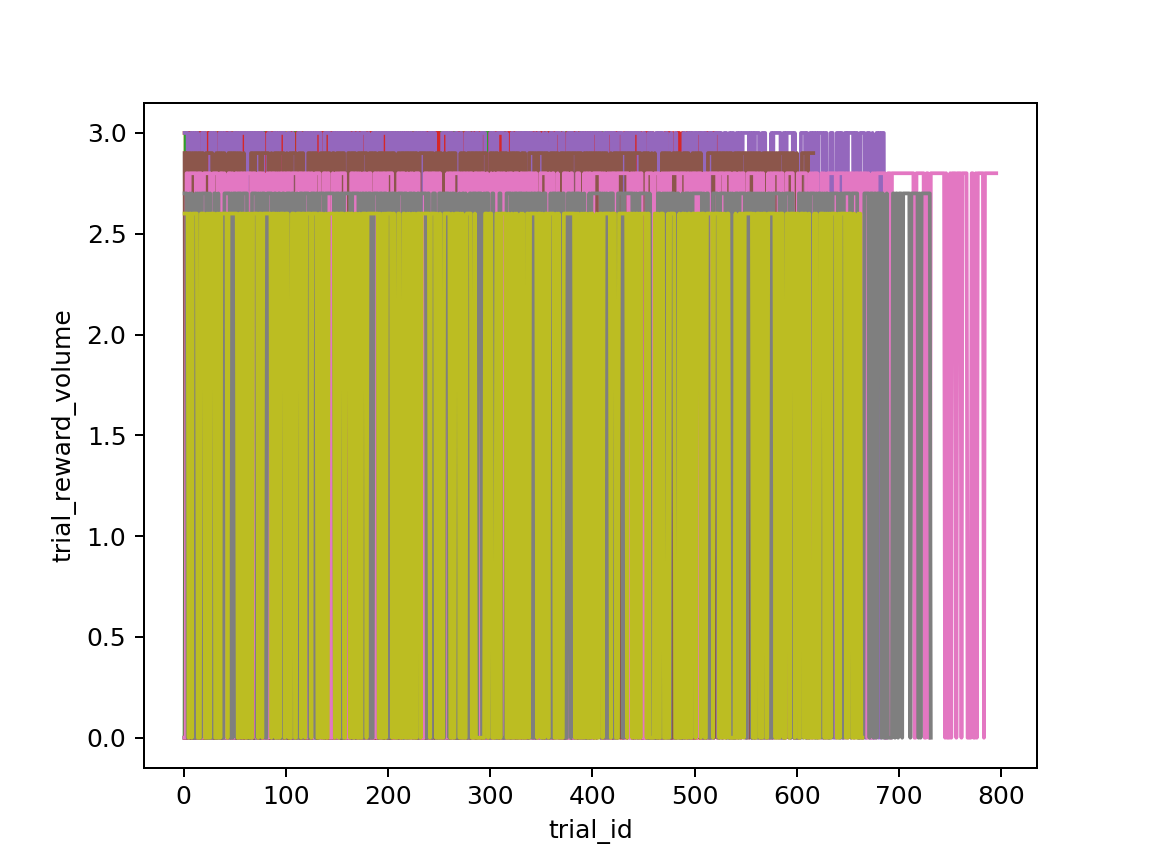

<AxesSubplot:xlabel='trial_id', ylabel='trial_reward_volume'>

In [234]:
fig, ax = plt.subplots()
data_per_sub = data[data['subject_uuid'] == s_uuid]
sns.lineplot(data = data_per_sub, x ='trial_id', y = 'trial_reward_volume', hue = 'session_uuid', legend=False)


Info about sessions per subject 
- every 2 days (sometimes 4 days - weekend?)


Potential Q: Is there a drop in performance after longer break?

## Getting stimulus contrast data

In [54]:
data_per_sub[['trial_stim_contrast_left', 'trial_stim_contrast_right']]

,trial_stim_contrast_left,trial_stim_contrast_right
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
4928,0.0,0.5
4929,0.0,1.0
4930,1.0,0.0
4931,0.0,0.5


Reproducing data preparation from the paper

In [56]:
data['signed_contrast'] = data['trial_stim_contrast_right'] - data['trial_stim_contrast_left']
data['report_right'] = data['trial_response_choice'] == "CCW"

<IPython.core.display.Javascript object>


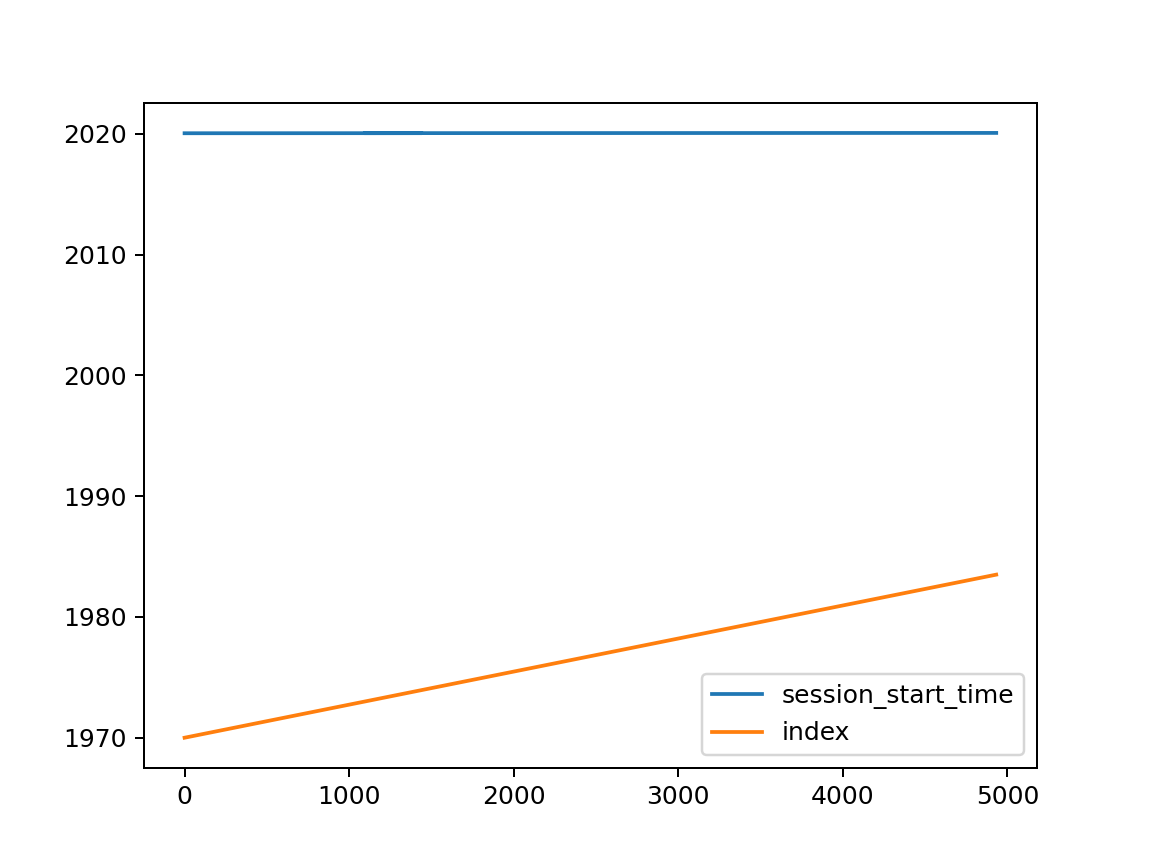

<AxesSubplot:>

In [224]:
data_per_sub = data_per_sub.sort_values('session_start_time')
data_per_sub[['session_start_time', 'index']].plot()

<IPython.core.display.Javascript object>


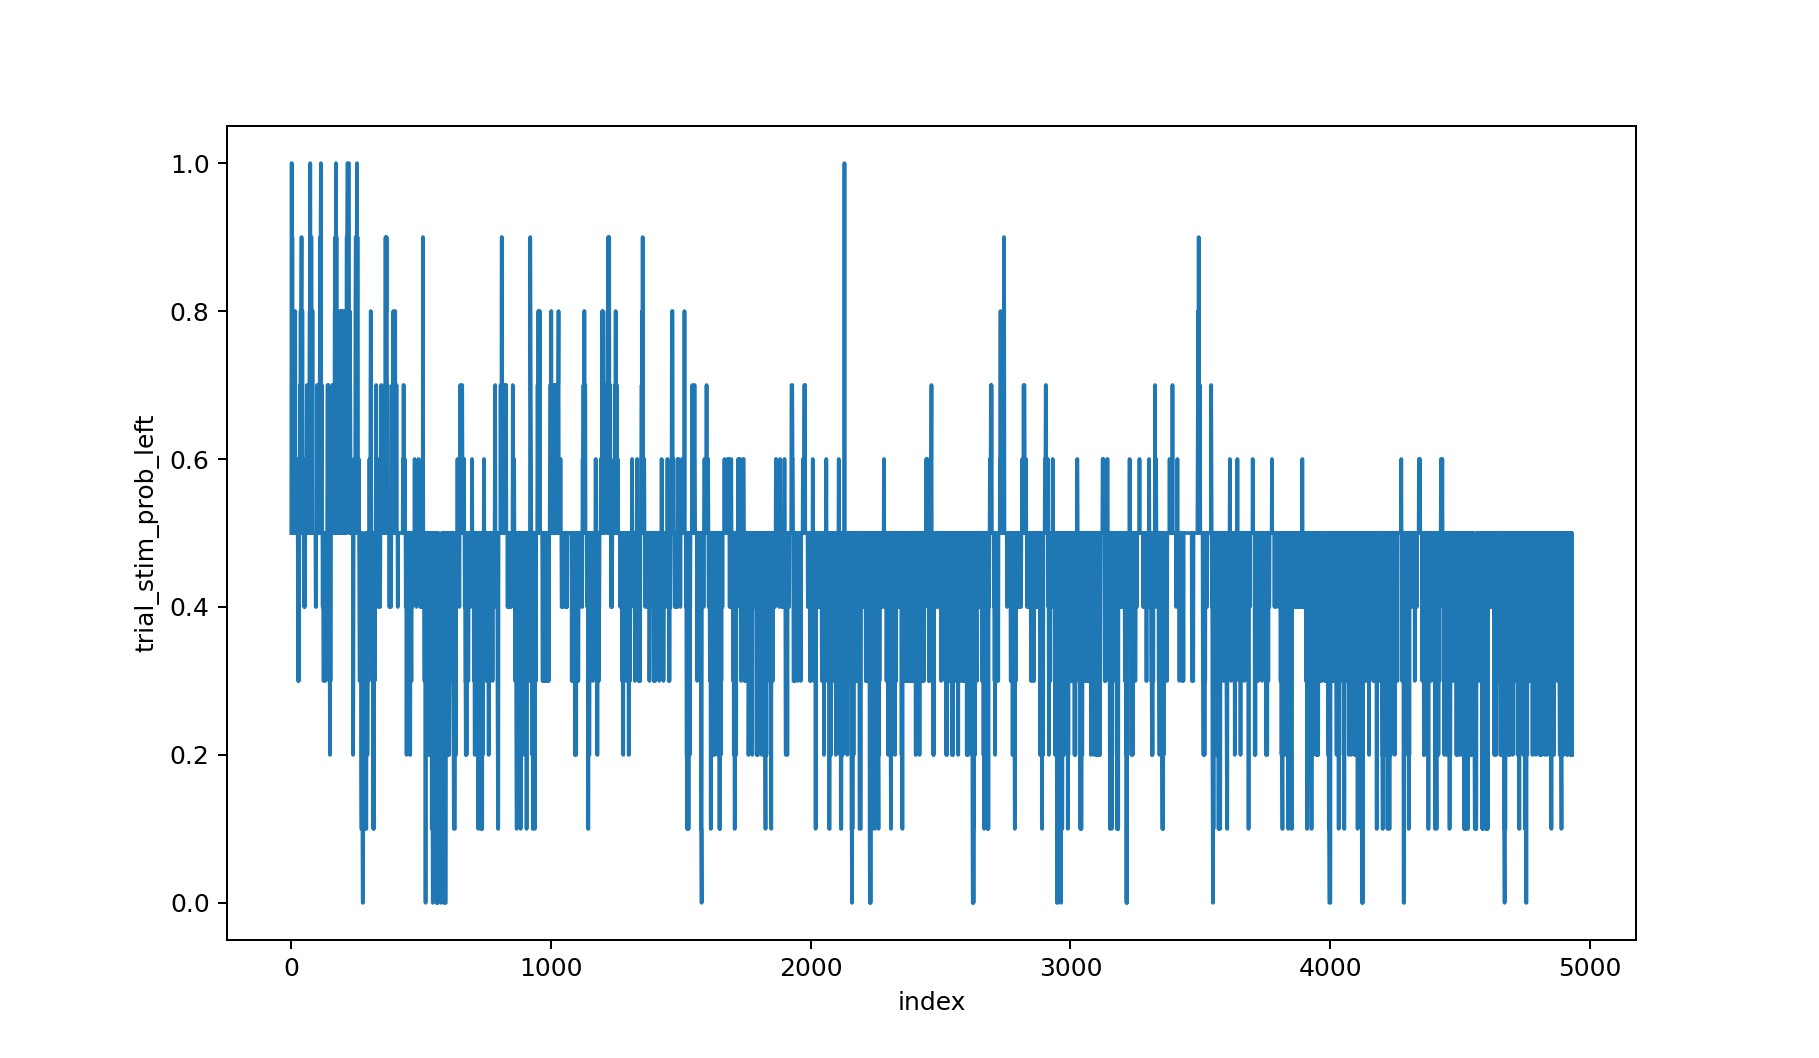

<AxesSubplot:xlabel='index', ylabel='trial_stim_prob_left'>

In [232]:
fig, ax = plt.subplots()
sns.lineplot(data=data_per_sub, x = 'index', y='trial_stim_prob_left')
# FOLLOW UP: see differences between mice

<IPython.core.display.Javascript object>


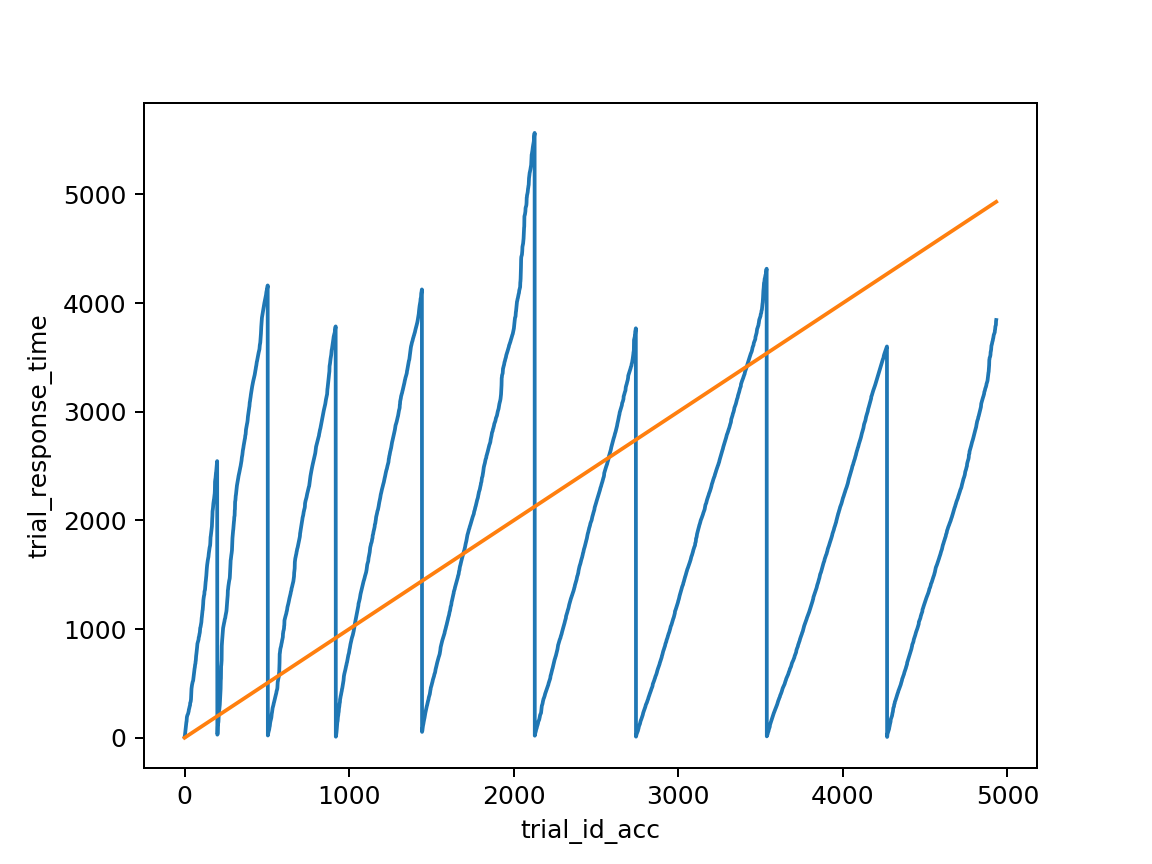

<AxesSubplot:xlabel='trial_id_acc', ylabel='trial_response_time'>

In [75]:
fig, ax = plt.subplots()
sns.lineplot(data=data_per_sub, x = 'trial_id_acc', y='trial_response_time')

We see that for each trial we need to subtract start time in order to get absolute times

In [84]:
data_per_sub['trial_response_time'] - data_per_sub['trial_start_time']


0        7.7019
127      7.2039
128     22.0845
129      7.5412
130     19.4972
         ...   
4491     1.3737
4492     1.4511
4493     3.1397
4495     2.4957
4932     6.0712
Length: 4933, dtype: float64

trial start time -> trial stim on time -> go cue time -> response time

Looking at 

In [239]:
ss_uuid = '1dbfd8ae-93ff-44d9-9fd8-14ac6e4575ab'
trial_id = 10
st_df = data_per_sub[data_per_sub['session_uuid'] == ss_uuid]
t_df = st_df[st_df['trial_id'] == trial_id]

finding the time columns

In [242]:
cols =[c for c in t_df.columns if 'time' in c ]
pd.DataFrame(cols)


,0
0,session_start_time
1,trial_start_time
2,trial_end_time
3,trial_response_time
4,trial_stim_on_time
5,trial_feedback_time
6,trial_go_cue_time
7,trial_go_cue_trigger_time
8,session_end_time


In [243]:
t_df_t = t_df[cols].T
t_df_t.columns = ['time']
t_df_t[~t_df_t.index.isin(['session_start_time', 'session_end_time'])].sort_values(by='time')

,time
trial_start_time,114.0396
trial_stim_on_time,114.6276
trial_go_cue_trigger_time,114.628
trial_go_cue_time,114.659
trial_response_time,132.0122
trial_feedback_time,132.0123
trial_end_time,133.571403


to get absolute times we need to subtruct the start time 
- 'decision time' = trial_response_time - trial_go_cue_time (trial_stim_on_time) 

# getting the wrong/right decision

In [119]:
data_per_sub['trial_response_choice'], data_per_sub['report_right']

(0       CCW
 1       CCW
 2        CW
 3       CCW
 4        CW
        ... 
 4928    CCW
 4929     CW
 4930     CW
 4931     CW
 4932     CW
 Name: trial_response_choice, Length: 4933, dtype: object,
 0        True
 1        True
 2       False
 3        True
 4       False
         ...  
 4928     True
 4929    False
 4930    False
 4931    False
 4932    False
 Name: report_right, Length: 4933, dtype: bool)

Deriving a correct answer

In [125]:
data_per_sub['GT_right'] = data_per_sub['signed_contrast'] > 0
data_per_sub['correct'] = data_per_sub['GT_right'] == data_per_sub['report_right']

/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_42096/3125341685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_per_sub['GT_right'] = data_per_sub['signed_contrast'] > 0


In [204]:
mat = data_per_sub[['correct','session_start_time', 'trial_id']]
mat['correct'] = mat['correct'].astype('int')
mat['session_start_time'] = mat['session_start_time'].dt.strftime("%m/%d")
mat = mat.pivot(columns=['session_start_time'], values='correct', index='trial_id').T

/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_42096/3519265263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat['correct'] = mat['correct'].astype('int')
/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_42096/3519265263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat['session_start_time'] = mat['session_start_time'].dt.strftime("%m/%d")


# Plot of correct answers for one subject in each trial

<IPython.core.display.Javascript object>


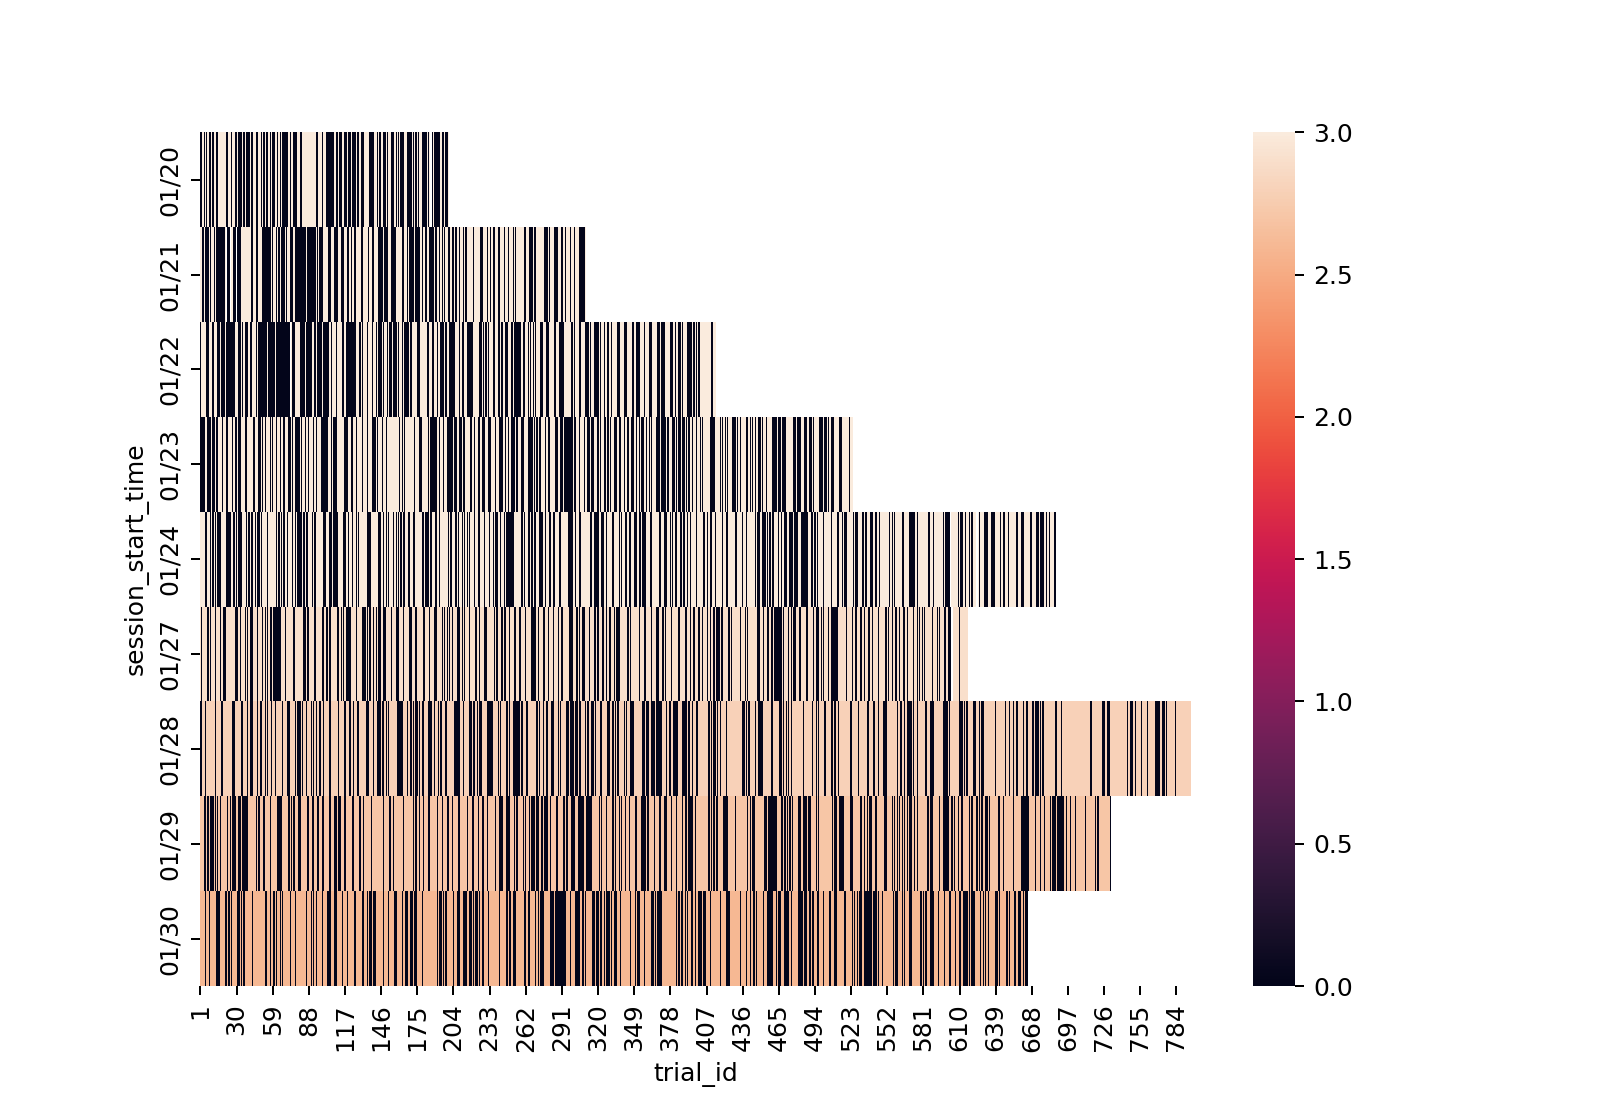

<AxesSubplot:xlabel='trial_id', ylabel='session_start_time'>

In [246]:
fig, ax = plt.subplots()

sns.heatmap(data = mat)

# Plot of reward volume for one subject per trial

/var/folders/gm/0smpdjfx2bsgbk13mwt50zdc0000gn/T/ipykernel_42096/2437220139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat['session_start_time'] = mat['session_start_time'].dt.strftime("%m/%d")


<IPython.core.display.Javascript object>


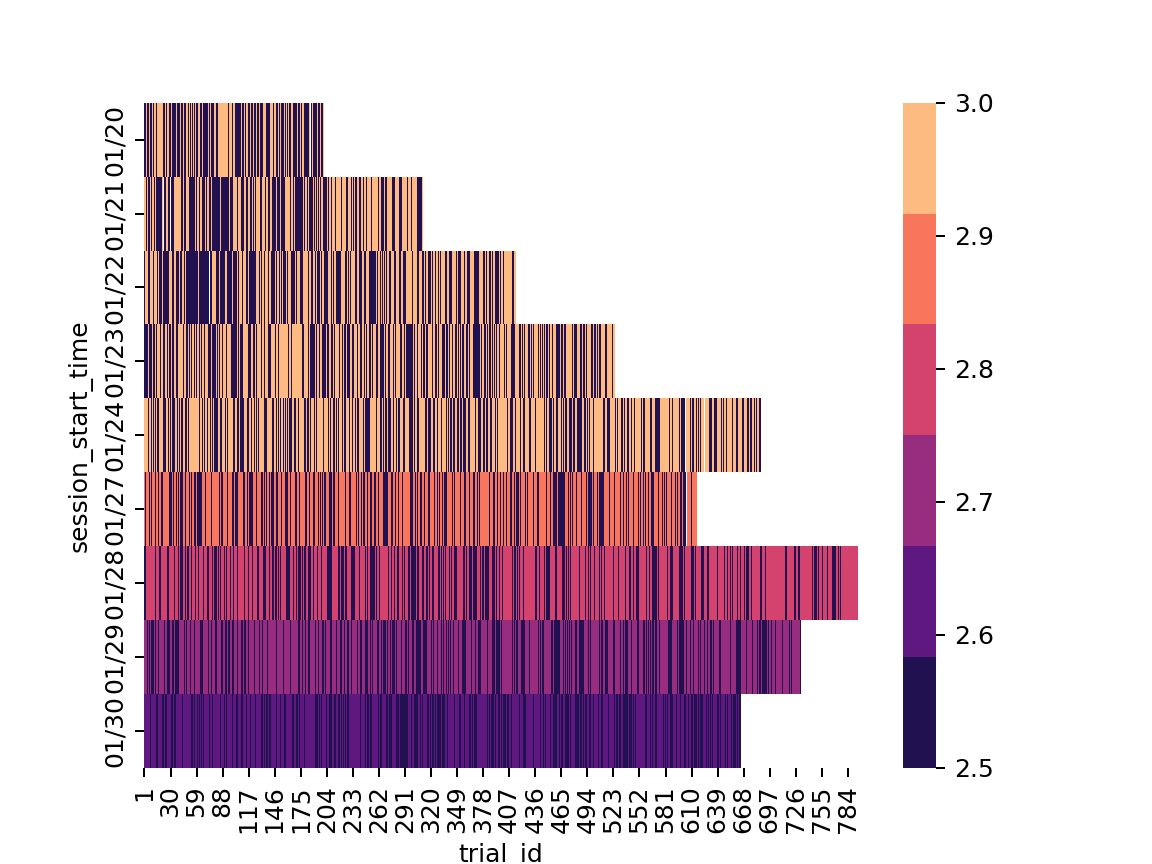

<AxesSubplot:xlabel='trial_id', ylabel='session_start_time'>

In [268]:
mat = data_per_sub[['trial_reward_volume', 'session_start_time', 'trial_id']]
mat['session_start_time'] = mat['session_start_time'].dt.strftime("%m/%d")
mat = mat.pivot(columns=['session_start_time'], values='trial_reward_volume', index='trial_id').T
fig, ax = plt.subplots()

sns.heatmap(data = mat, vmin= 2.5, cmap=sns.color_palette('magma'))